# End-to-End Routing Test: RL vs Dijkstra Baseline

This notebook tests **complete end-to-end routing** from terminal to terminal using:
- **New Logic**: Terminal → GS selection → RL routing (GS-to-GS) → GS → Terminal
- **Baseline**: Terminal → GS selection → Dijkstra routing (GS-to-GS) → GS → Terminal

**Key Features**:
- Tests full routing pipeline (terminal selection → routing → delivery)
- Compares RL (new logic) vs Dijkstra (baseline)
- Comprehensive metrics: success rate, hops, distance, latency, efficiency
- Detailed path analysis and visualizations


## 1. Setup & Configuration


In [1]:
# Setup paths and imports
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import warnings
import time
import torch
warnings.filterwarnings('ignore')

# Add backend to path
backend_path = os.path.abspath('..')
if backend_path not in sys.path:
    sys.path.insert(0, backend_path)

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✓ Setup complete")


✓ Setup complete


In [2]:
# Import project modules
from config import Config
from models.database import Database
from agent.dueling_dqn import DuelingDQNAgent
from environment.routing_env import RoutingEnvironment
from environment.state_builder import RoutingStateBuilder
from api.routing_bp import (
    calculate_path_dijkstra, 
    calculate_path_rl,
    find_best_ground_station,
    calculate_distance
)

# Initialize
config = Config.get_yaml_config()
db = Database()
db.connect()

print("✓ Modules loaded")
print(f"✓ Database connected: {db.db.name}")
print(f"✓ Config loaded")


✓ Modules loaded
✓ Database connected: aiprancs
✓ Config loaded


## 4. End-to-End Test Function


## 2. Load Network Data


In [3]:
# Load nodes and terminals from database
nodes_collection = db.get_collection('nodes')
terminals_collection = db.get_collection('terminals')

# Get all operational nodes
nodes = list(nodes_collection.find({'isOperational': True}, {'_id': 0}))

# Get all terminals
terminals = list(terminals_collection.find({}, {'_id': 0}))

print(f"✓ Loaded {len(nodes)} operational nodes")
print(f"✓ Loaded {len(terminals)} terminals")

if len(nodes) < 5 or len(terminals) < 2:
    raise ValueError("Need at least 5 nodes and 2 terminals for testing")


✓ Loaded 53 operational nodes
✓ Loaded 30 terminals


## 3. Load Best RL Model


In [4]:
# Load checkpoint to get correct dimensions
best_model_path_str = config.get('rl_agent', {}).get('best_model_path', './models/best_models')
if not os.path.isabs(best_model_path_str):
    backend_root = Path(os.path.abspath('..'))
    best_model_dir = backend_root / best_model_path_str.lstrip('./')
else:
    best_model_dir = Path(best_model_path_str)
best_model_path = best_model_dir / 'best_model.pt'

# Load checkpoint to get state_dim and action_dim
state_dim = None
action_dim = None

if best_model_path.exists():
    try:
        checkpoint = torch.load(str(best_model_path), map_location='cpu', weights_only=False)
        if 'state_dim' in checkpoint:
            state_dim = checkpoint['state_dim']
        if 'action_dim' in checkpoint:
            action_dim = checkpoint['action_dim']
        
        # Infer from state_dict if not in checkpoint
        if state_dim is None and 'q_network_state_dict' in checkpoint:
            for key in checkpoint['q_network_state_dict'].keys():
                if 'input_norm.weight' in key:
                    state_dim = checkpoint['q_network_state_dict'][key].shape[0]
                    break
        
        if action_dim is None and 'q_network_state_dict' in checkpoint:
            for key in checkpoint['q_network_state_dict'].keys():
                if 'advantage_stream.6.weight' in key:
                    action_dim = checkpoint['q_network_state_dict'][key].shape[0]
                    break
        
        logger.info(f"Loaded dimensions from checkpoint: state_dim={state_dim}, action_dim={action_dim}")
    except Exception as e:
        logger.warning(f"Could not read checkpoint dimensions: {e}")

# If checkpoint dimensions not available, use config
if state_dim is None or action_dim is None:
    state_builder_temp = RoutingStateBuilder(config)
    env_temp = RoutingEnvironment(nodes=nodes, terminals=terminals[:2] if terminals else [], config=config, max_steps=15)
    state_dim = state_builder_temp.state_dimension
    action_dim = env_temp.action_space.n
    logger.info(f"Using dimensions from config: state_dim={state_dim}, action_dim={action_dim}")

# Create agent
agent = DuelingDQNAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    config=config
)

# Load model
if best_model_path.exists():
    try:
        agent.load(str(best_model_path))
        agent.eval()
        logger.info(f"✓ Loaded trained model from {best_model_path}")
        model_loaded = True
    except Exception as e:
        logger.warning(f"Could not load model: {e}. Using untrained model.")
        agent.eval()
        model_loaded = False
else:
    logger.info("No trained model found. Using untrained model for testing.")
    agent.eval()
    model_loaded = False

print(f"\n📊 Model Status:")
print(f"  State dimension: {state_dim}")
print(f"  Action dimension: {action_dim}")
print(f"  Model loaded: {model_loaded}")


INFO:__main__:Loaded dimensions from checkpoint: state_dim=974, action_dim=53
INFO:agent.dueling_dqn:Initializing DuelingDQN Agent on device: cpu
INFO:agent.dueling_dqn:DuelingDQN Agent initialized: state_dim=974, action_dim=53
INFO:agent.dueling_dqn:Agent loaded from /Users/anhnon/AI-PRACNS/Backend/models/best_models/best_model.pt
INFO:__main__:✓ Loaded trained model from /Users/anhnon/AI-PRACNS/Backend/models/best_models/best_model.pt



📊 Model Status:
  State dimension: 974
  Action dimension: 53
  Model loaded: True


## 5. Run End-to-End Tests


In [5]:
def test_end_to_end_routing(
    source_terminal: Dict,
    dest_terminal: Dict,
    nodes: List[Dict],
    agent: DuelingDQNAgent,
    config: Dict
) -> Dict:
    """
    Test complete end-to-end routing: Terminal → GS → Routing → GS → Terminal
    
    Uses NEW LOGIC:
    1. Select GS for source terminal (separate algorithm)
    2. Select GS for dest terminal (separate algorithm)
    3. RL routing between GS (model's job)
    4. Complete path: Terminal → Source GS → ... → Dest GS → Terminal
    
    Args:
        source_terminal: Source terminal
        dest_terminal: Destination terminal
        nodes: All operational nodes
        agent: Trained RL agent
        config: Configuration dict
    
    Returns:
        Dict with routing results for both RL and Dijkstra
    """
    # Calculate direct distance between terminals
    terminal_distance_km = calculate_distance(
        source_terminal.get('position'),
        dest_terminal.get('position')
    ) / 1000.0
    
    # Step 1: Select Ground Stations for terminals (separate algorithm)
    source_gs = find_best_ground_station(source_terminal, nodes)
    dest_gs = find_best_ground_station(dest_terminal, nodes)
    
    if not source_gs or not dest_gs:
        return {
            'source_terminal_id': source_terminal.get('terminalId'),
            'dest_terminal_id': dest_terminal.get('terminalId'),
            'terminal_distance_km': terminal_distance_km,
            'source_gs_id': None,
            'dest_gs_id': None,
            'rl_success': False,
            'rl_error': 'Cannot find ground stations',
            'dijkstra_success': False,
            'dijkstra_error': 'Cannot find ground stations'
        }
    
    # Step 2: RL Routing (GS-to-GS)
    rl_result = {
        'success': False,
        'error': None,
        'path': None,
        'hops': 0,
        'distance_km': 0,
        'latency_ms': 0,
        'computation_time_ms': 0
    }
    
    try:
        rl_start_time = time.time()
        
        # Create environment
        env = RoutingEnvironment(
            nodes=nodes,
            terminals=[source_terminal, dest_terminal],
            config=config,
            max_steps=15
        )
        
        # Reset with explicit ground stations
        state, info = env.reset(
            options={
                'source_terminal_id': source_terminal.get('terminalId'),
                'dest_terminal_id': dest_terminal.get('terminalId'),
                'source_ground_station': source_gs,
                'dest_ground_station': dest_gs
            }
        )
        
        # Route using RL agent
        done = False
        step_count = 0
        max_steps = 10
        
        while not done and step_count < max_steps:
            action = agent.select_action(state, deterministic=True)
            next_state, reward, terminated, truncated, step_info = env.step(action)
            done = terminated or truncated
            state = next_state
            step_count += 1
        
        if done and terminated:
            rl_path = env.get_path_result()
            rl_result['success'] = True
            rl_result['path'] = rl_path
            rl_result['hops'] = len(rl_path.get('path', [])) - 1 if rl_path.get('path') else 0
            rl_result['distance_km'] = rl_path.get('totalDistance', 0)
            rl_result['latency_ms'] = rl_path.get('estimatedLatency', 0)
        else:
            rl_result['error'] = 'Max steps reached or truncated'
        
        rl_result['computation_time_ms'] = (time.time() - rl_start_time) * 1000
        
    except Exception as e:
        rl_result['error'] = str(e)
        logger.error(f"RL routing error: {e}")
    
    # Step 3: Dijkstra Routing (GS-to-GS) - Baseline
    dijkstra_result = {
        'success': False,
        'error': None,
        'path': None,
        'hops': 0,
        'distance_km': 0,
        'latency_ms': 0,
        'computation_time_ms': 0
    }
    
    try:
        dijkstra_start_time = time.time()
        
        dijkstra_path = calculate_path_dijkstra(
            source_terminal,
            dest_terminal,
            nodes,
            resource_aware=True
        )
        
        dijkstra_result['computation_time_ms'] = (time.time() - dijkstra_start_time) * 1000
        
        if dijkstra_path and dijkstra_path.get('success', False):
            dijkstra_result['success'] = True
            dijkstra_result['path'] = dijkstra_path
            dijkstra_result['hops'] = len(dijkstra_path.get('path', [])) - 1 if dijkstra_path.get('path') else 0
            dijkstra_result['distance_km'] = dijkstra_path.get('totalDistance', 0)
            dijkstra_result['latency_ms'] = dijkstra_path.get('estimatedLatency', 0)
        else:
            dijkstra_result['error'] = 'Dijkstra path not found'
            
    except Exception as e:
        dijkstra_result['error'] = str(e)
        logger.error(f"Dijkstra routing error: {e}")
    
    # Calculate efficiency (direct distance / path distance)
    rl_efficiency = terminal_distance_km / rl_result['distance_km'] if rl_result['distance_km'] > 0 else 0
    dijkstra_efficiency = terminal_distance_km / dijkstra_result['distance_km'] if dijkstra_result['distance_km'] > 0 else 0
    
    return {
        'source_terminal_id': source_terminal.get('terminalId'),
        'dest_terminal_id': dest_terminal.get('terminalId'),
        'terminal_distance_km': terminal_distance_km,
        'source_gs_id': source_gs['nodeId'],
        'dest_gs_id': dest_gs['nodeId'],
        'gs_distance_km': calculate_distance(source_gs.get('position'), dest_gs.get('position')) / 1000.0,
        # RL results
        'rl_success': rl_result['success'],
        'rl_error': rl_result['error'],
        'rl_hops': rl_result['hops'],
        'rl_distance_km': rl_result['distance_km'],
        'rl_latency_ms': rl_result['latency_ms'],
        'rl_efficiency': rl_efficiency,
        'rl_computation_time_ms': rl_result['computation_time_ms'],
        'rl_path': rl_result['path'],
        # Dijkstra results
        'dijkstra_success': dijkstra_result['success'],
        'dijkstra_error': dijkstra_result['error'],
        'dijkstra_hops': dijkstra_result['hops'],
        'dijkstra_distance_km': dijkstra_result['distance_km'],
        'dijkstra_latency_ms': dijkstra_result['latency_ms'],
        'dijkstra_efficiency': dijkstra_efficiency,
        'dijkstra_computation_time_ms': dijkstra_result['computation_time_ms'],
        'dijkstra_path': dijkstra_result['path']
    }

print("✓ Test function defined")


✓ Test function defined


## 6. Comprehensive Analysis


## 5. Run End-to-End Tests


## 7. Visualizations


In [6]:
# Run comprehensive end-to-end tests
num_tests = 50
results = []

logger.info("=" * 60)
logger.info(f"End-to-End Routing Test: RL (New Logic) vs Dijkstra Baseline")
logger.info(f"Testing {num_tests} terminal pairs")
logger.info("=" * 60)

for i in range(num_tests):
    # Randomly select 2 different terminals
    if len(terminals) < 2:
        break
    
    indices = np.random.choice(len(terminals), size=2, replace=False)
    source_terminal = terminals[indices[0]]
    dest_terminal = terminals[indices[1]]
    
    logger.info(f"\nTest {i+1}/{num_tests}: {source_terminal.get('terminalId')} → {dest_terminal.get('terminalId')}")
    
    result = test_end_to_end_routing(
        source_terminal=source_terminal,
        dest_terminal=dest_terminal,
        nodes=nodes,
        agent=agent,
        config=config
    )
    
    results.append(result)
    
    # Log result
    if result['rl_success']:
        logger.info(f"  ✅ RL: {result['rl_hops']} hops, {result['rl_distance_km']:.1f}km, {result['rl_latency_ms']:.2f}ms")
    else:
        logger.info(f"  ❌ RL: {result['rl_error']}")
    
    if result['dijkstra_success']:
        logger.info(f"  ✅ Dijkstra: {result['dijkstra_hops']} hops, {result['dijkstra_distance_km']:.1f}km, {result['dijkstra_latency_ms']:.2f}ms")

print(f"\n✓ Completed {len(results)} tests")


INFO:__main__:============================================================
INFO:__main__:End-to-End Routing Test: RL (New Logic) vs Dijkstra Baseline
INFO:__main__:Testing 50 terminal pairs
INFO:__main__:============================================================
INFO:__main__:
Test 1/50: TERM-0022 → TERM-0028
INFO:api.routing_bp:✅ Selected optimal Ground Station GS-035 for terminal TERM-0022 (score: 0.744, distance: 16.6km, utilization: 36.0%, battery: 100.0%, packet_loss: 0.05%, connections: 0)
INFO:api.routing_bp:✅ Selected optimal Ground Station GS-041 for terminal TERM-0028 (score: 0.493, distance: 19.9km, utilization: 36.0%, battery: 100.0%, packet_loss: 0.05%, connections: 0)
INFO:environment.routing_env:Dynamic max_steps: 26 (operational_nodes=53, base=15, estimated_hops=26)
INFO:environment.routing_env:RL starting from explicit source GS: GS-035
INFO:environment.routing_env:RL reached exact destination GS: GS-041
INFO:api.routing_bp:✅ Selected optimal Ground Station GS-035 fo


✓ Completed 50 tests


## 8. Detailed Path Analysis


## 6. Comprehensive Analysis


## 9. Performance by Distance Range


In [7]:
# Convert to DataFrame
df = pd.DataFrame(results)

# Calculate statistics
rl_success_rate = df['rl_success'].mean() * 100
dijkstra_success_rate = df['dijkstra_success'].mean() * 100

print("=" * 60)
print("END-TO-END ROUTING TEST RESULTS")
print("=" * 60)
print(f"\n📊 Success Rates:")
print(f"  RL (New Logic):  {rl_success_rate:.1f}% ({df['rl_success'].sum()}/{len(df)})")
print(f"  Dijkstra (Baseline): {dijkstra_success_rate:.1f}% ({df['dijkstra_success'].sum()}/{len(df)})")

# Compare successful paths
successful_rl = df[df['rl_success'] == True]
successful_dijkstra = df[df['dijkstra_success'] == True]
both_successful = df[(df['rl_success'] == True) & (df['dijkstra_success'] == True)]

if len(successful_rl) > 0:
    print(f"\n📈 RL Performance (New Logic - {len(successful_rl)} successful):")
    print(f"  Mean hops:      {successful_rl['rl_hops'].mean():.2f} (std: {successful_rl['rl_hops'].std():.2f})")
    print(f"  Mean distance:  {successful_rl['rl_distance_km'].mean():.2f} km (std: {successful_rl['rl_distance_km'].std():.2f})")
    print(f"  Mean latency:   {successful_rl['rl_latency_ms'].mean():.2f} ms (std: {successful_rl['rl_latency_ms'].std():.2f})")
    print(f"  Mean efficiency: {successful_rl['rl_efficiency'].mean():.3f}")
    print(f"  Mean computation time: {successful_rl['rl_computation_time_ms'].mean():.2f} ms")

if len(successful_dijkstra) > 0:
    print(f"\n📈 Dijkstra Performance (Baseline - {len(successful_dijkstra)} successful):")
    print(f"  Mean hops:      {successful_dijkstra['dijkstra_hops'].mean():.2f} (std: {successful_dijkstra['dijkstra_hops'].std():.2f})")
    print(f"  Mean distance:  {successful_dijkstra['dijkstra_distance_km'].mean():.2f} km (std: {successful_dijkstra['dijkstra_distance_km'].std():.2f})")
    print(f"  Mean latency:   {successful_dijkstra['dijkstra_latency_ms'].mean():.2f} ms (std: {successful_dijkstra['dijkstra_latency_ms'].std():.2f})")
    print(f"  Mean efficiency: {successful_dijkstra['dijkstra_efficiency'].mean():.3f}")
    print(f"  Mean computation time: {successful_dijkstra['dijkstra_computation_time_ms'].mean():.2f} ms")

if len(both_successful) > 0:
    print(f"\n🔄 Direct Comparison (Both Successful - {len(both_successful)} cases):")
    
    # Hops comparison
    rl_better_hops = (both_successful['rl_hops'] < both_successful['dijkstra_hops']).sum()
    dijkstra_better_hops = (both_successful['dijkstra_hops'] < both_successful['rl_hops']).sum()
    equal_hops = (both_successful['rl_hops'] == both_successful['dijkstra_hops']).sum()
    
    print(f"  Hops:")
    print(f"    RL better:     {rl_better_hops} ({rl_better_hops/len(both_successful)*100:.1f}%)")
    print(f"    Dijkstra better: {dijkstra_better_hops} ({dijkstra_better_hops/len(both_successful)*100:.1f}%)")
    print(f"    Equal:         {equal_hops} ({equal_hops/len(both_successful)*100:.1f}%)")
    print(f"    Avg difference: {both_successful['dijkstra_hops'].mean() - both_successful['rl_hops'].mean():.2f} hops (RL uses fewer)")
    
    # Distance comparison
    rl_better_distance = (both_successful['rl_distance_km'] < both_successful['dijkstra_distance_km']).sum()
    dijkstra_better_distance = (both_successful['dijkstra_distance_km'] < both_successful['rl_distance_km']).sum()
    equal_distance = (both_successful['rl_distance_km'] == both_successful['dijkstra_distance_km']).sum()
    
    print(f"\n  Distance:")
    print(f"    RL better:     {rl_better_distance} ({rl_better_distance/len(both_successful)*100:.1f}%)")
    print(f"    Dijkstra better: {dijkstra_better_distance} ({dijkstra_better_distance/len(both_successful)*100:.1f}%)")
    print(f"    Equal:         {equal_distance} ({equal_distance/len(both_successful)*100:.1f}%)")
    print(f"    Avg difference: {both_successful['dijkstra_distance_km'].mean() - both_successful['rl_distance_km'].mean():.2f} km")
    
    # Latency comparison
    rl_better_latency = (both_successful['rl_latency_ms'] < both_successful['dijkstra_latency_ms']).sum()
    dijkstra_better_latency = (both_successful['dijkstra_latency_ms'] < both_successful['rl_latency_ms']).sum()
    
    print(f"\n  Latency:")
    print(f"    RL better:     {rl_better_latency} ({rl_better_latency/len(both_successful)*100:.1f}%)")
    print(f"    Dijkstra better: {dijkstra_better_latency} ({dijkstra_better_latency/len(both_successful)*100:.1f}%)")
    print(f"    Avg difference: {both_successful['dijkstra_latency_ms'].mean() - both_successful['rl_latency_ms'].mean():.2f} ms")
    
    # Efficiency comparison
    rl_better_efficiency = (both_successful['rl_efficiency'] > both_successful['dijkstra_efficiency']).sum()
    dijkstra_better_efficiency = (both_successful['dijkstra_efficiency'] > both_successful['rl_efficiency']).sum()
    
    print(f"\n  Efficiency (higher is better):")
    print(f"    RL better:     {rl_better_efficiency} ({rl_better_efficiency/len(both_successful)*100:.1f}%)")
    print(f"    Dijkstra better: {dijkstra_better_efficiency} ({dijkstra_better_efficiency/len(both_successful)*100:.1f}%)")
    
    # Computation time comparison
    print(f"\n  Computation Time:")
    print(f"    RL avg:        {both_successful['rl_computation_time_ms'].mean():.2f} ms")
    print(f"    Dijkstra avg:  {both_successful['dijkstra_computation_time_ms'].mean():.2f} ms")
    print(f"    Speedup:       {both_successful['dijkstra_computation_time_ms'].mean() / both_successful['rl_computation_time_ms'].mean():.2f}x")

# Show example paths
print(f"\n📋 Example Paths (First 5):")
for idx, row in df.head(5).iterrows():
    print(f"\n  {row['source_terminal_id']} → {row['dest_terminal_id']} ({row['terminal_distance_km']:.1f}km direct):")
    print(f"    GS: {row['source_gs_id']} → {row['dest_gs_id']} ({row['gs_distance_km']:.1f}km)")
    if row['rl_success']:
        print(f"    ✅ RL:       {row['rl_hops']} hops, {row['rl_distance_km']:.1f}km, {row['rl_latency_ms']:.2f}ms")
    else:
        print(f"    ❌ RL:       {row['rl_error']}")
    if row['dijkstra_success']:
        print(f"    ✅ Dijkstra: {row['dijkstra_hops']} hops, {row['dijkstra_distance_km']:.1f}km, {row['dijkstra_latency_ms']:.2f}ms")


END-TO-END ROUTING TEST RESULTS

📊 Success Rates:
  RL (New Logic):  100.0% (50/50)
  Dijkstra (Baseline): 100.0% (50/50)

📈 RL Performance (New Logic - 50 successful):
  Mean hops:      3.16 (std: 0.42)
  Mean distance:  10605.85 km (std: 5875.28)
  Mean latency:   51.18 ms (std: 21.01)
  Mean efficiency: 0.960
  Mean computation time: 97.67 ms

📈 Dijkstra Performance (Baseline - 50 successful):
  Mean hops:      4.56 (std: 1.15)
  Mean distance:  18170.17 km (std: 6111.29)
  Mean latency:   90.23 ms (std: 20.90)
  Mean efficiency: 0.544
  Mean computation time: 11.68 ms

🔄 Direct Comparison (Both Successful - 50 cases):
  Hops:
    RL better:     44 (88.0%)
    Dijkstra better: 1 (2.0%)
    Equal:         5 (10.0%)
    Avg difference: 1.40 hops (RL uses fewer)

  Distance:
    RL better:     48 (96.0%)
    Dijkstra better: 2 (4.0%)
    Equal:         0 (0.0%)
    Avg difference: 7564.32 km

  Latency:
    RL better:     49 (98.0%)
    Dijkstra better: 1 (2.0%)
    Avg difference: 39.

## 10. Summary & Conclusion


## 7. Visualizations


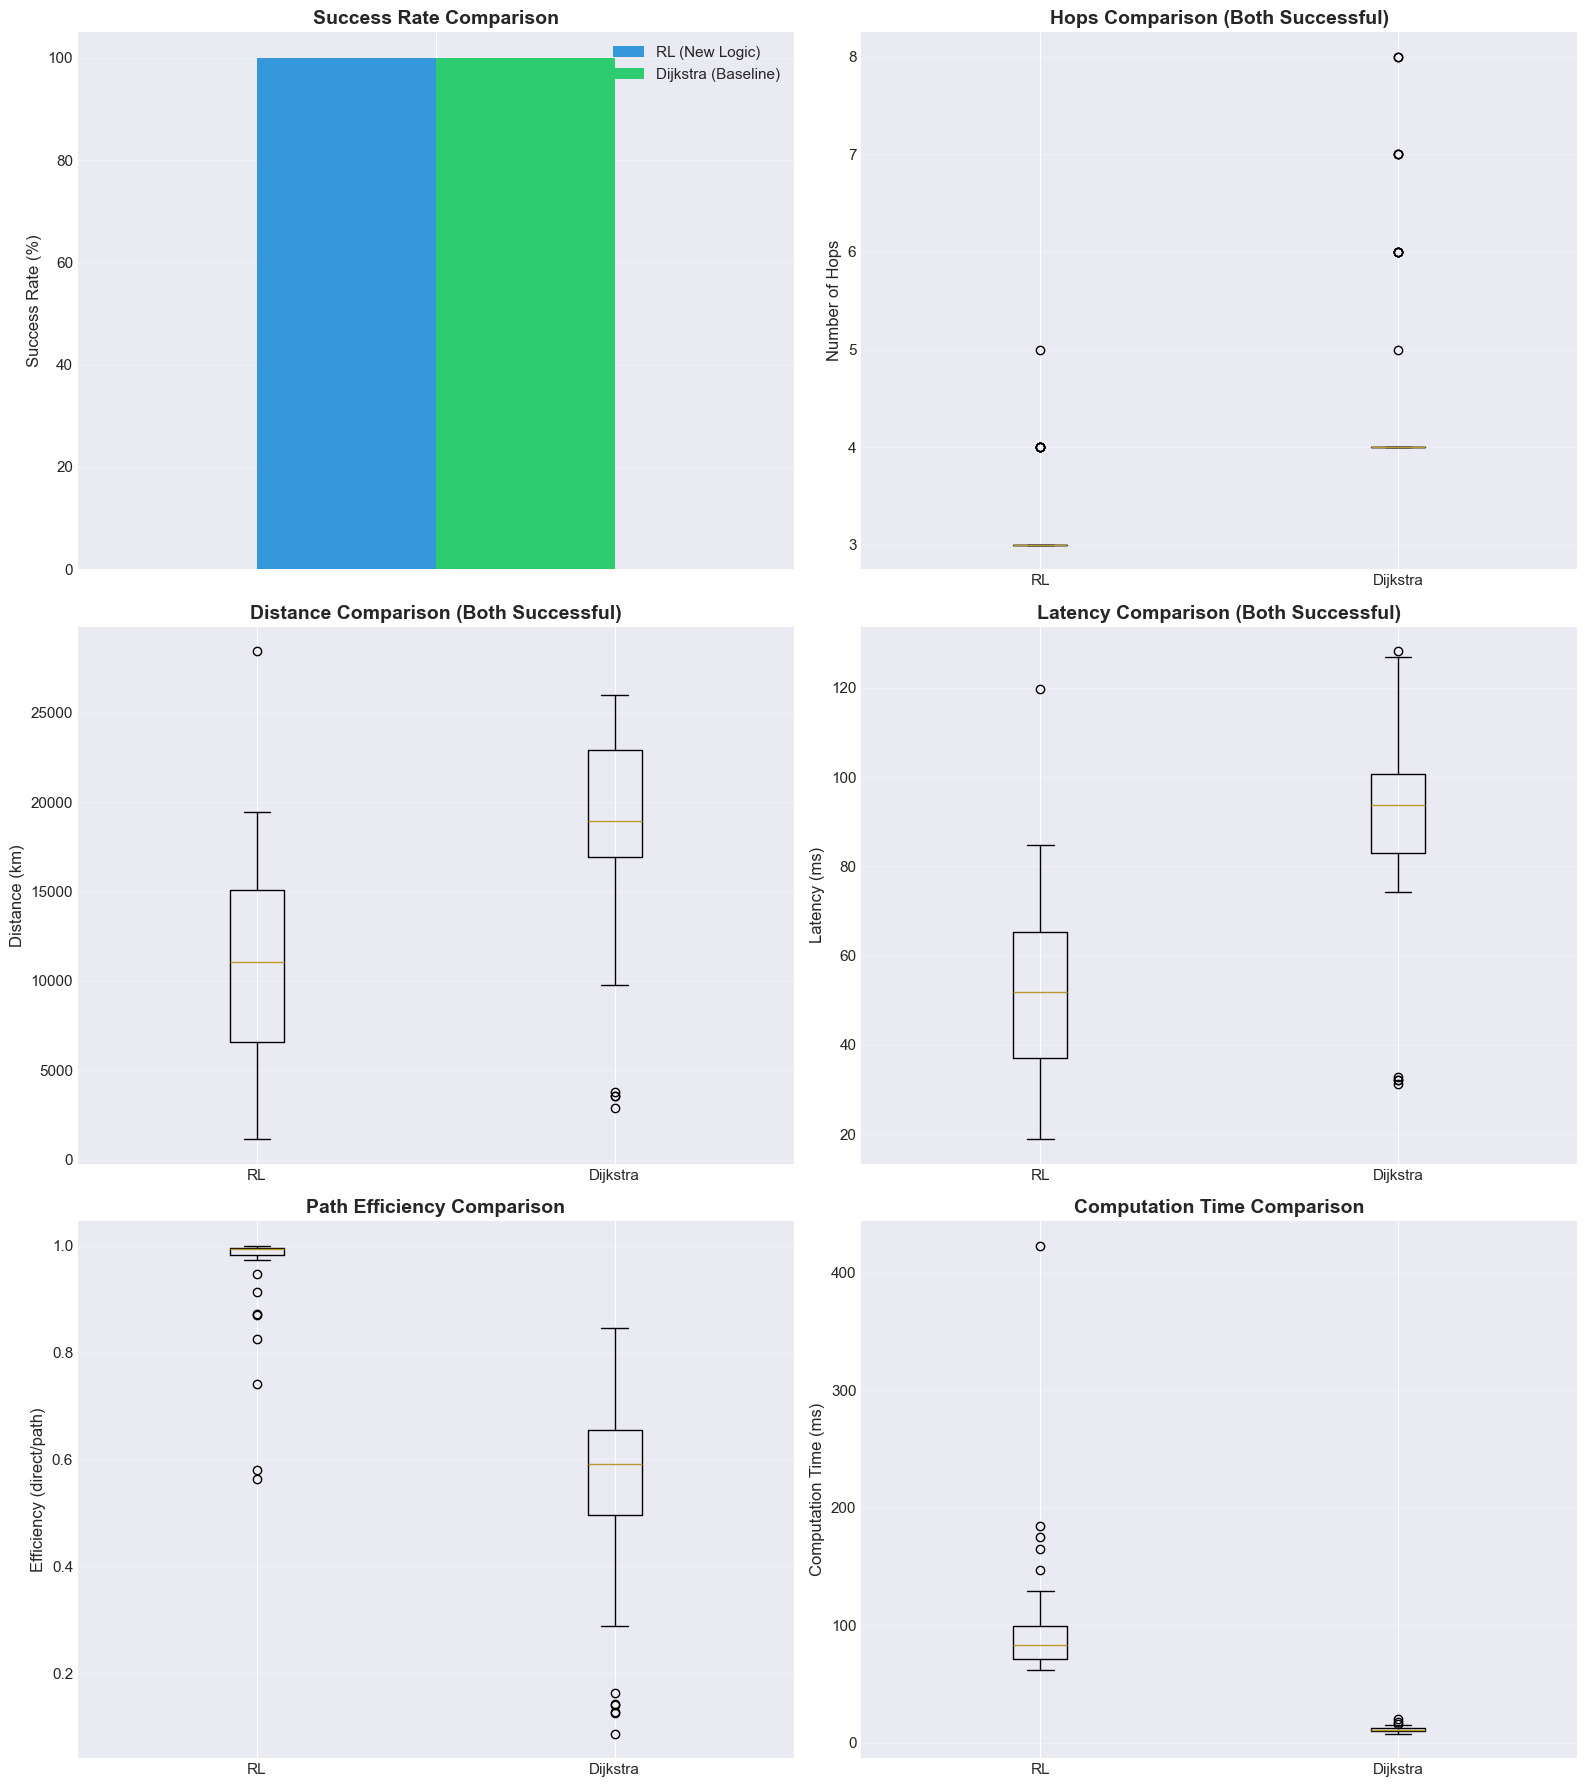

✓ Visualizations complete


In [8]:
# Create comprehensive visualizations
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Success Rate Comparison
ax1 = axes[0, 0]
success_data = {
    'RL (New Logic)': [rl_success_rate],
    'Dijkstra (Baseline)': [dijkstra_success_rate]
}
df_success = pd.DataFrame(success_data)
df_success.plot(kind='bar', ax=ax1, color=['#3498db', '#2ecc71'])
ax1.set_ylabel('Success Rate (%)', fontsize=12)
ax1.set_title('Success Rate Comparison', fontsize=14, fontweight='bold')
ax1.set_xticklabels([''], rotation=0)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 105])

# 2. Hops Comparison
ax2 = axes[0, 1]
if len(both_successful) > 0:
    hops_data = {
        'RL': both_successful['rl_hops'].values,
        'Dijkstra': both_successful['dijkstra_hops'].values
    }
    ax2.boxplot([hops_data['RL'], hops_data['Dijkstra']], labels=['RL', 'Dijkstra'])
    ax2.set_ylabel('Number of Hops', fontsize=12)
    ax2.set_title('Hops Comparison (Both Successful)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
else:
    ax2.text(0.5, 0.5, 'No successful paths\nfor comparison', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Hops Comparison', fontsize=14, fontweight='bold')

# 3. Distance Comparison
ax3 = axes[1, 0]
if len(both_successful) > 0:
    distance_data = {
        'RL': both_successful['rl_distance_km'].values,
        'Dijkstra': both_successful['dijkstra_distance_km'].values
    }
    ax3.boxplot([distance_data['RL'], distance_data['Dijkstra']], labels=['RL', 'Dijkstra'])
    ax3.set_ylabel('Distance (km)', fontsize=12)
    ax3.set_title('Distance Comparison (Both Successful)', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
else:
    ax3.text(0.5, 0.5, 'No successful paths\nfor comparison', 
             ha='center', va='center', transform=ax3.transAxes, fontsize=12)
    ax3.set_title('Distance Comparison', fontsize=14, fontweight='bold')

# 4. Latency Comparison
ax4 = axes[1, 1]
if len(both_successful) > 0:
    latency_data = {
        'RL': both_successful['rl_latency_ms'].values,
        'Dijkstra': both_successful['dijkstra_latency_ms'].values
    }
    ax4.boxplot([latency_data['RL'], latency_data['Dijkstra']], labels=['RL', 'Dijkstra'])
    ax4.set_ylabel('Latency (ms)', fontsize=12)
    ax4.set_title('Latency Comparison (Both Successful)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
else:
    ax4.text(0.5, 0.5, 'No successful paths\nfor comparison', 
             ha='center', va='center', transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Latency Comparison', fontsize=14, fontweight='bold')

# 5. Efficiency Comparison
ax5 = axes[2, 0]
if len(both_successful) > 0:
    efficiency_data = {
        'RL': both_successful['rl_efficiency'].values,
        'Dijkstra': both_successful['dijkstra_efficiency'].values
    }
    ax5.boxplot([efficiency_data['RL'], efficiency_data['Dijkstra']], labels=['RL', 'Dijkstra'])
    ax5.set_ylabel('Efficiency (direct/path)', fontsize=12)
    ax5.set_title('Path Efficiency Comparison', fontsize=14, fontweight='bold')
    ax5.grid(True, alpha=0.3, axis='y')
else:
    ax5.text(0.5, 0.5, 'No successful paths\nfor comparison', 
             ha='center', va='center', transform=ax5.transAxes, fontsize=12)
    ax5.set_title('Efficiency Comparison', fontsize=14, fontweight='bold')

# 6. Computation Time Comparison
ax6 = axes[2, 1]
if len(both_successful) > 0:
    time_data = {
        'RL': both_successful['rl_computation_time_ms'].values,
        'Dijkstra': both_successful['dijkstra_computation_time_ms'].values
    }
    ax6.boxplot([time_data['RL'], time_data['Dijkstra']], labels=['RL', 'Dijkstra'])
    ax6.set_ylabel('Computation Time (ms)', fontsize=12)
    ax6.set_title('Computation Time Comparison', fontsize=14, fontweight='bold')
    ax6.grid(True, alpha=0.3, axis='y')
else:
    ax6.text(0.5, 0.5, 'No successful paths\nfor comparison', 
             ha='center', va='center', transform=ax6.transAxes, fontsize=12)
    ax6.set_title('Computation Time Comparison', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")


## 8. Detailed Path Analysis


In [9]:
# Show detailed path for a successful example
successful_examples = df[df['rl_success'] == True]

if len(successful_examples) > 0:
    example = successful_examples.iloc[0]
    
    print("=" * 60)
    print(f"Detailed End-to-End Path Analysis")
    print("=" * 60)
    print(f"\n📍 Route: {example['source_terminal_id']} → {example['dest_terminal_id']}")
    print(f"  Direct distance: {example['terminal_distance_km']:.2f} km")
    print(f"  GS route: {example['source_gs_id']} → {example['dest_gs_id']} ({example['gs_distance_km']:.2f} km)")
    
    if example['rl_path'] and example['rl_path'].get('path'):
        print(f"\n🤖 RL Path (New Logic) - {example['rl_hops']} hops, {example['rl_distance_km']:.2f}km, {example['rl_latency_ms']:.2f}ms:")
        for i, segment in enumerate(example['rl_path']['path']):
            seg_type = segment.get('type', 'unknown')
            seg_id = segment.get('id', 'unknown')
            seg_name = segment.get('name', seg_id)
            print(f"  {i+1}. [{seg_type.upper()}] {seg_id} - {seg_name}")
    
    if example['dijkstra_path'] and example['dijkstra_path'].get('path'):
        print(f"\n📐 Dijkstra Path (Baseline) - {example['dijkstra_hops']} hops, {example['dijkstra_distance_km']:.2f}km, {example['dijkstra_latency_ms']:.2f}ms:")
        for i, segment in enumerate(example['dijkstra_path']['path']):
            seg_type = segment.get('type', 'unknown')
            seg_id = segment.get('id', 'unknown')
            seg_name = segment.get('name', seg_id)
            print(f"  {i+1}. [{seg_type.upper()}] {seg_id} - {seg_name}")
    
    # Comparison
    if example['rl_success'] and example['dijkstra_success']:
        print(f"\n🔄 Comparison:")
        hops_diff = example['dijkstra_hops'] - example['rl_hops']
        distance_diff = example['dijkstra_distance_km'] - example['rl_distance_km']
        latency_diff = example['dijkstra_latency_ms'] - example['rl_latency_ms']
        
        print(f"  Hops:      RL uses {abs(hops_diff)} {'fewer' if hops_diff > 0 else 'more'} hops")
        print(f"  Distance:  RL path is {abs(distance_diff):.2f} km {'shorter' if distance_diff > 0 else 'longer'}")
        print(f"  Latency:   RL path is {abs(latency_diff):.2f} ms {'faster' if latency_diff > 0 else 'slower'}")
else:
    print("No successful RL paths to analyze")


Detailed End-to-End Path Analysis

📍 Route: TERM-0022 → TERM-0028
  Direct distance: 7974.69 km
  GS route: GS-035 → GS-041 (7999.25 km)

🤖 RL Path (New Logic) - 3 hops, 8035.75km, 41.80ms:
  1. [TERMINAL] TERM-0022 - VEHICLE Terminal 23 (HARD)
  2. [NODE] GS-035 - Ground Station Chicago
  3. [NODE] GS-041 - Ground Station Moscow
  4. [TERMINAL] TERM-0028 - AIRCRAFT Terminal 29 (HARD)

📐 Dijkstra Path (Baseline) - 4 hops, 18057.78km, 92.53ms:
  1. [TERMINAL] TERM-0022 - VEHICLE Terminal 23 (HARD)
  2. [NODE] GS-035 - Ground Station Chicago
  3. [NODE] MEO-026 - MEO Satellite 3
  4. [NODE] GS-041 - Ground Station Moscow
  5. [TERMINAL] TERM-0028 - AIRCRAFT Terminal 29 (HARD)

🔄 Comparison:
  Hops:      RL uses 1 fewer hops
  Distance:  RL path is 10022.03 km shorter
  Latency:   RL path is 50.73 ms faster


## 9. Performance by Distance Range


In [10]:
# Analyze performance by terminal distance ranges
df['distance_range'] = pd.cut(
    df['terminal_distance_km'],
    bins=[0, 2000, 5000, 10000, float('inf')],
    labels=['Near (<2k km)', 'Medium (2-5k km)', 'Far (5-10k km)', 'Very Far (>10k km)']
)

print("=" * 60)
print("Performance by Terminal Distance Range")
print("=" * 60)

for dist_range in df['distance_range'].cat.categories:
    range_df = df[df['distance_range'] == dist_range]
    if len(range_df) == 0:
        continue
    
    print(f"\n📊 {dist_range}:")
    print(f"  Total tests: {len(range_df)}")
    
    rl_success = range_df['rl_success'].sum()
    dijkstra_success = range_df['dijkstra_success'].sum()
    
    print(f"  RL success:      {rl_success}/{len(range_df)} ({rl_success/len(range_df)*100:.1f}%)")
    print(f"  Dijkstra success: {dijkstra_success}/{len(range_df)} ({dijkstra_success/len(range_df)*100:.1f}%)")
    
    rl_successful = range_df[range_df['rl_success'] == True]
    dijkstra_successful = range_df[range_df['dijkstra_success'] == True]
    
    if len(rl_successful) > 0:
        print(f"  RL avg hops:      {rl_successful['rl_hops'].mean():.2f}")
        print(f"  RL avg distance:  {rl_successful['rl_distance_km'].mean():.2f} km")
        print(f"  RL avg latency:   {rl_successful['rl_latency_ms'].mean():.2f} ms")
    
    if len(dijkstra_successful) > 0:
        print(f"  Dijkstra avg hops:      {dijkstra_successful['dijkstra_hops'].mean():.2f}")
        print(f"  Dijkstra avg distance:  {dijkstra_successful['dijkstra_distance_km'].mean():.2f} km")
        print(f"  Dijkstra avg latency:   {dijkstra_successful['dijkstra_latency_ms'].mean():.2f} ms")


Performance by Terminal Distance Range

📊 Near (<2k km):
  Total tests: 3
  RL success:      3/3 (100.0%)
  Dijkstra success: 3/3 (100.0%)
  RL avg hops:      3.00
  RL avg distance:  1446.57 km
  RL avg latency:   19.83 ms
  Dijkstra avg hops:      4.00
  Dijkstra avg distance:  8044.54 km
  Dijkstra avg latency:   48.90 ms

📊 Medium (2-5k km):
  Total tests: 7
  RL success:      7/7 (100.0%)
  Dijkstra success: 7/7 (100.0%)
  RL avg hops:      3.00
  RL avg distance:  2556.07 km
  RL avg latency:   23.53 ms
  Dijkstra avg hops:      4.00
  Dijkstra avg distance:  13686.56 km
  Dijkstra avg latency:   67.68 ms

📊 Far (5-10k km):
  Total tests: 13
  RL success:      13/13 (100.0%)
  Dijkstra success: 13/13 (100.0%)
  RL avg hops:      3.00
  RL avg distance:  8139.19 km
  RL avg latency:   42.15 ms
  Dijkstra avg hops:      5.00
  Dijkstra avg distance:  15200.74 km
  Dijkstra avg latency:   86.96 ms

📊 Very Far (>10k km):
  Total tests: 27
  RL success:      27/27 (100.0%)
  Dijkstra 

## 10. Summary & Conclusion


In [11]:
print("=" * 60)
print("END-TO-END ROUTING TEST SUMMARY")
print("=" * 60)
print(f"\n✅ Test completed: {len(results)} terminal pairs tested")
print(f"\n📊 Key Findings:")

print(f"\n1. Success Rates:")
print(f"   RL (New Logic):      {rl_success_rate:.1f}%")
print(f"   Dijkstra (Baseline): {dijkstra_success_rate:.1f}%")

if len(successful_rl) > 0:
    print(f"\n2. RL Performance (New Logic):")
    print(f"   - Mean hops:      {successful_rl['rl_hops'].mean():.2f}")
    print(f"   - Mean distance:  {successful_rl['rl_distance_km'].mean():.2f} km")
    print(f"   - Mean latency:   {successful_rl['rl_latency_ms'].mean():.2f} ms")
    print(f"   - Mean efficiency: {successful_rl['rl_efficiency'].mean():.3f}")

if len(successful_dijkstra) > 0:
    print(f"\n3. Dijkstra Performance (Baseline):")
    print(f"   - Mean hops:      {successful_dijkstra['dijkstra_hops'].mean():.2f}")
    print(f"   - Mean distance:  {successful_dijkstra['dijkstra_distance_km'].mean():.2f} km")
    print(f"   - Mean latency:   {successful_dijkstra['dijkstra_latency_ms'].mean():.2f} ms")
    print(f"   - Mean efficiency: {successful_dijkstra['dijkstra_efficiency'].mean():.3f}")

if len(both_successful) > 0:
    print(f"\n4. Direct Comparison (Both Successful):")
    avg_rl_hops = both_successful['rl_hops'].mean()
    avg_dijkstra_hops = both_successful['dijkstra_hops'].mean()
    avg_rl_distance = both_successful['rl_distance_km'].mean()
    avg_dijkstra_distance = both_successful['dijkstra_distance_km'].mean()
    avg_rl_latency = both_successful['rl_latency_ms'].mean()
    avg_dijkstra_latency = both_successful['dijkstra_latency_ms'].mean()
    
    print(f"   - Hops:      RL {avg_rl_hops:.2f} vs Dijkstra {avg_dijkstra_hops:.2f} (diff: {avg_dijkstra_hops - avg_rl_hops:.2f})")
    print(f"   - Distance:  RL {avg_rl_distance:.2f}km vs Dijkstra {avg_dijkstra_distance:.2f}km (diff: {avg_dijkstra_distance - avg_rl_distance:.2f}km)")
    print(f"   - Latency:   RL {avg_rl_latency:.2f}ms vs Dijkstra {avg_dijkstra_latency:.2f}ms (diff: {avg_dijkstra_latency - avg_rl_latency:.2f}ms)")
    
    # Determine winner
    rl_wins = 0
    dijkstra_wins = 0
    ties = 0
    
    for idx, row in both_successful.iterrows():
        rl_score = 0
        dijkstra_score = 0
        
        if row['rl_hops'] < row['dijkstra_hops']:
            rl_score += 1
        elif row['dijkstra_hops'] < row['rl_hops']:
            dijkstra_score += 1
        
        if row['rl_distance_km'] < row['dijkstra_distance_km']:
            rl_score += 1
        elif row['dijkstra_distance_km'] < row['rl_distance_km']:
            dijkstra_score += 1
        
        if row['rl_latency_ms'] < row['dijkstra_latency_ms']:
            rl_score += 1
        elif row['dijkstra_latency_ms'] < row['rl_latency_ms']:
            dijkstra_score += 1
        
        if rl_score > dijkstra_score:
            rl_wins += 1
        elif dijkstra_score > rl_score:
            dijkstra_wins += 1
        else:
            ties += 1
    
    print(f"\n5. Overall Winner (based on hops, distance, latency):")
    print(f"   RL wins:      {rl_wins} ({rl_wins/len(both_successful)*100:.1f}%)")
    print(f"   Dijkstra wins: {dijkstra_wins} ({dijkstra_wins/len(both_successful)*100:.1f}%)")
    print(f"   Ties:         {ties} ({ties/len(both_successful)*100:.1f}%)")

print(f"\n💡 Conclusion:")
if rl_success_rate >= 80 and len(both_successful) > 0:
    if both_successful['rl_hops'].mean() < both_successful['dijkstra_hops'].mean():
        print(f"  ✅ RL (New Logic) performs BETTER than Dijkstra baseline")
        print(f"     - Higher success rate: {rl_success_rate:.1f}% vs {dijkstra_success_rate:.1f}%")
        print(f"     - Fewer hops on average: {both_successful['rl_hops'].mean():.2f} vs {both_successful['dijkstra_hops'].mean():.2f}")
    else:
        print(f"  ⚠️  RL (New Logic) performs similarly to Dijkstra baseline")
        print(f"     - Success rate: {rl_success_rate:.1f}% vs {dijkstra_success_rate:.1f}%")
elif rl_success_rate >= 50:
    print(f"  ⚠️  RL (New Logic) shows moderate performance")
    print(f"     - May need more training or tuning")
else:
    print(f"  ❌ RL (New Logic) needs significant improvement")
    print(f"     - Consider retraining with new logic")

print(f"\n🎯 Key Insight:")
print(f"  The new logic separates concerns:")
print(f"  1. GS selection for terminals (separate algorithm)")
print(f"  2. Routing between GS (RL model's job)")
print(f"  This allows the model to focus purely on routing optimization!")

print("\n" + "=" * 60)


END-TO-END ROUTING TEST SUMMARY

✅ Test completed: 50 terminal pairs tested

📊 Key Findings:

1. Success Rates:
   RL (New Logic):      100.0%
   Dijkstra (Baseline): 100.0%

2. RL Performance (New Logic):
   - Mean hops:      3.16
   - Mean distance:  10605.85 km
   - Mean latency:   51.18 ms
   - Mean efficiency: 0.960

3. Dijkstra Performance (Baseline):
   - Mean hops:      4.56
   - Mean distance:  18170.17 km
   - Mean latency:   90.23 ms
   - Mean efficiency: 0.544

4. Direct Comparison (Both Successful):
   - Hops:      RL 3.16 vs Dijkstra 4.56 (diff: 1.40)
   - Distance:  RL 10605.85km vs Dijkstra 18170.17km (diff: 7564.32km)
   - Latency:   RL 51.18ms vs Dijkstra 90.23ms (diff: 39.06ms)

5. Overall Winner (based on hops, distance, latency):
   RL wins:      49 (98.0%)
   Dijkstra wins: 1 (2.0%)
   Ties:         0 (0.0%)

💡 Conclusion:
  ✅ RL (New Logic) performs BETTER than Dijkstra baseline
     - Higher success rate: 100.0% vs 100.0%
     - Fewer hops on average: 3.16 vs 4.